<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Numbrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

##Numbrix Optimization Problem

\begin{align}
    & \min
    & & 1 &  \\
    & \text{s.t.}
    & & \sum_{ i \in I  } \sum_{ j \in J  } X_{i,j,k} = 1 &  \qquad \forall k \in K \tag{1}\\
    &&& \sum_{ k \in K  } X_{i,j,k} = 1 &  \qquad \forall i,j \in I \times J \tag{2}\\
    & \text{w.b.}
    & & X & \qquad \in \left\{ 0 , 1 \right \} \tag{3}
\end{align}

In [ ]:
row1 = [1,41,47,53]
row2 = [7,45,51]
row3 = [9,63]
row4 = [15,81]
row5 = [21,61]
row6 = [19,35,79]
row7 = [25,31,69,73]

v = {}

# Row  Colors and Numbers
counter = 0
for i in [2,4,6,8]:
  v[i,2] = row1[counter]
  v[i,8] = row7[counter]
  counter += 1

counter = 0
for i in [3,5,7]:
  v[i,3] = row2[counter]
  v[i,7] = row6[counter]
  counter += 1

counter = 0
for i in [2,8]:
  v[i,4] = row3[counter]
  v[i,6] = row5[counter]
  counter += 1

counter = 0
for i in [3,7]:
  v[i,5] = row4[counter]
  counter += 1

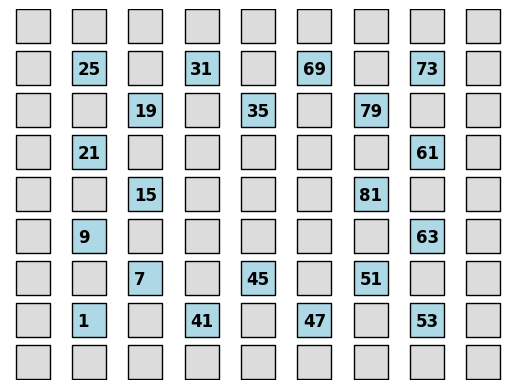

In [ ]:
x = {}
for i,j in list(itertools.product(range(1,10),range(1,10))):
  x[i,j] = 0

for i,j in v:
  x[i,j] = v[i,j]

for i,j in x:
  if x[i,j] == 0:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
  else:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')

plt.axis('off')
plt.show()

In [ ]:
#from pyomo.contrib.latex_printer import latex_printer
#latex_printer(model)

\begin{align}
    & \min
    & & 1 &  \\
    & \text{s.t.}
    & & \sum_{ i \in I  } \sum_{ j \in J  } X_{i,j,k} = 1 &  \qquad \forall k \in K  \\
    &&& \sum_{ k \in K  } X_{i,j,k} = 1 &  \qquad \forall i,j \in I \times J  \\
    &&& X_{2,1,k + 1} + X_{1,2,k + 1} - X_{1,1,k} = 0 &  \qquad \forall k \in \{1, 2, 3, \ldots 80\}  \\
    &
    & & X & \qquad \in \left\{ 0 , 1 \right \}  
\end{align}

In [ ]:
model = ConcreteModel()
model.I = RangeSet(1,9)
model.J = RangeSet(1,9)
model.K = RangeSet(1,81)
model.X = Var(model.I, model.J, model.K, domain = Binary)

for i,j in v:
  model.X[(i,j,v[i,j])].fix(1)

#All values should be used once
def c_rule1(model,k):
  return sum(model.X[(i,j,k)] for i in model.I for j in model.J) == 1
model.c1 = Constraint(model.K, rule = c_rule1)

#All squares have only one value
def c_rule2(model,i,j):
  return sum(model.X[(i,j,k)] for k in model.K) == 1
model.c2 = Constraint(model.I,model.J, rule = c_rule2)

# Corners must be sequential
def snake(model,i,j,k):
    #Corners
    if (i,j) == (1,1):
      return model.X[(i,j),k] - model.X[(i,j+1),k+1] - model.X[(i+1,j),k+1] <= 0
    elif (i,j) == (9,1):
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i,j+1),k+1] <= 0
    elif (i,j) == (1,9):
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i+1,j),k+1] <= 0
    elif (i,j) == (9,9):
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i-1,j),k+1] <= 0
    #Bottom row
    elif 1 < i < 9 and j == 1:
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i+1,j),k+1] - model.X[(i,j+1),k+1] <= 0
    #Top row
    elif 1 < i < 9 and j == 9:
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i+1,j),k+1] - model.X[(i,j-1),k+1] <= 0
    #Left edge
    elif 1 < j < 9 and i == 1:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i,j+1),k+1] - model.X[(i+1,j),k+1] <= 0
    #Right edge
    elif 1 < j < 9 and i == 9:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i,j+1),k+1] - model.X[(i-1,j),k+1] <= 0
    #Interior
    elif 1 < i < 9 and 1 < j < 9:
      return model.X[(i,j),k] - model.X[(i+1,j),k+1] - model.X[(i-1,j),k+1] - model.X[(i,j+1),k+1] - model.X[(i,j-1),k+1] <= 0
    else: return Constraint.Skip()
model.snake = Constraint(list(itertools.product(range(1,10),range(1,10))),range(1,81),rule = snake)

model.obj = Objective(expr=1)

In [ ]:
# Solve model

opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

x_vals = pd.Series(model.X.extract_values(), name='vals')
g = x_vals[x_vals>0]
p = g.reset_index()
b = np.reshape(p['level_2'],(9,9), order = 'F')
np.flip(b,0)
h = {}
for i in range(1,82):
  h[np.where(b==i)[1][0]+1,np.where(b==i)[0][0]+1] = i

Solution is Optimal
Solve Time:  0.22


<ipython-input-90-9750d63c2e88>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t[0][:i],t[1][:i],'-bo',c='r', lw=2);


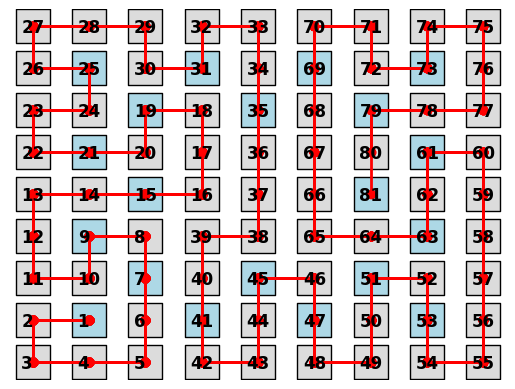

In [ ]:
from IPython import display
from time import sleep
!mkdir new_folder

t = np.reshape(list(h.keys()),(81,2)).T

plt.axis('off')

#for i in range(1,82):
#  if i in v.values():
#    plt.scatter(np.where(b==i)[1][0]+1,np.where(b==i)[0][0]+1, marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
#    plt.text(np.where(b==i)[1][0]+1-.15,np.where(b==i)[0][0]+1-.15,i, fontweight='bold',fontsize = '12')
#  else:
#    plt.scatter(np.where(b==i)[1][0]+1,np.where(b==i)[0][0]+1, marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
#    plt.text(np.where(b==i)[1][0]+1-.15,np.where(b==i)[0][0]+1-.15,i, fontweight='bold',fontsize = '12')

for i,j in x:
  if x[i,j] == 0:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
  else:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')

for i in range(1,len(t[0])+1):
  plt.plot(t[0][:i],t[1][:i],'-bo',c='r', lw=2);
  if x[(list(h.keys())[i-1][0],list(h.keys())[i-1][1])] == 0:
    #plt.scatter(list(h.keys())[i-1][0]-0.2,list(h.keys())[i-1][1]-0.15,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(list(h.keys())[i-1][0]-0.2,list(h.keys())[i-1][1]-0.15,i,fontweight='bold',fontsize='12')
  else: continue
  display.display(plt.gcf())
  plt.savefig('/content/new_folder/abc%d_%s'%(i,'pic.jpg'))
  display.clear_output(wait=True)
  sleep(0.02)
plt.show();